<h1><center><font size="6">Credit Card Fraud Detection Predictive Models（信用卡欺诈检测的预测模型）</center></h1>


# <a id='0'>目录</a>

- <a href='#1'>介绍</a>  
- <a href='#2'>导入包</a>  
- <a href='#3'>读取数据</a>  
- <a href='#4'>检查数据</a>  
    - <a href='#41'>数据概览</a>  
    - <a href='#42'>查看缺失数据</a>
    - <a href='#43'>查看数据的不平衡</a>
- <a href='#5'>数据探索</a>
- <a href='#6'>预测模型</a>  
    - <a href='#61'>RandomForrestClassifier</a> 
    - <a href='#62'>AdaBoostClassifier</a>     
    - <a href='#63'>CatBoostClassifier</a> 
    - <a href='#64'>XGBoost</a> 
    - <a href='#65'>LightGBM</a> 
- <a href='#7'>结论</a>

# <a id="1">介绍</a>  

该数据集包含2013年9月欧洲持卡人的信用卡交易记录，涵盖两天内发生的284,807笔交易，其中欺诈交易492笔。数据集高度不平衡，正样本（欺诈）仅占全部交易的0.172%。

由于保密要求，原始特征及相关背景信息未予提供。数据特征说明如下：

- V1-V28：通过主成分分析（PCA）转换后的数值型特征（原始特征未公开）

未经过PCA转换的特征：

- Time：每笔交易与数据集首笔交易的时间间隔（秒）

- Amount：交易金额（可用于基于样本的代价敏感学习）

目标变量：

- Class：标签值，1表示欺诈交易，0表示正常交易



# <a id="2">导入包</a>

In [1]:
import pandas as pd 
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline 
import plotly.graph_objs as go
import plotly.figure_factory as ff
from plotly import tools
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)


import gc
from datetime import datetime 
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from catboost import CatBoostClassifier
from sklearn import svm
from lightgbm import early_stopping, log_evaluation, record_evaluation
import lightgbm as lgb
from lightgbm import LGBMClassifier
import xgboost as xgb

pd.set_option('display.max_columns', 100)


RFC_METRIC = 'gini'  #metric used for RandomForrestClassifier
NUM_ESTIMATORS = 100 #number of estimators used for RandomForrestClassifier
NO_JOBS = 4 #number of parallel jobs used for RandomForrestClassifier


#TRAIN/VALIDATION/TEST SPLIT
#VALIDATION
VALID_SIZE = 0.20 # simple validation using train_test_split
TEST_SIZE = 0.20 # test size using_train_test_split

#CROSS-VALIDATION
NUMBER_KFOLDS = 5 #number of KFolds for cross-validation



RANDOM_STATE = 2018

MAX_ROUNDS = 1000 #lgb iterations
EARLY_STOP = 50 #lgb early stop 
OPT_ROUNDS = 1000  #To be adjusted based on best validation rounds
VERBOSE_EVAL = 50 #Print out metric result

IS_LOCAL = False

import os



# <a id="3">读取数据</a>

In [2]:
data_df = pd.read_csv("C:/Users/86181/Desktop/creditcard.csv")

# <a id="4">查看数据</a>

In [3]:
print("Credit Card Fraud Detection data -  rows:",data_df.shape[0]," columns:", data_df.shape[1])

Credit Card Fraud Detection data -  rows: 284807  columns: 31


## <a id="41">数据概览</a>

查看数据特征

In [4]:
data_df.head() # 查看前5行数据

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


数据细节

In [5]:
data_df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,1.168375e-15,3.416908e-16,-1.379537e-15,2.074095e-15,9.604066e-16,1.487313e-15,-5.556467e-16,1.213481e-16,-2.406331e-15,2.239053e-15,1.673327e-15,-1.247012e-15,8.190001e-16,1.207294e-15,4.887456e-15,1.437716e-15,-3.772171e-16,9.564149e-16,1.039917e-15,6.406204e-16,1.654067e-16,-3.568593e-16,2.578648e-16,4.473266e-15,5.340915e-16,1.683437e-15,-3.660091e-16,-1.227390e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,1.088850e+00,1.020713e+00,9.992014e-01,9.952742e-01,9.585956e-01,9.153160e-01,8.762529e-01,8.493371e-01,8.381762e-01,8.140405e-01,7.709250e-01,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,-2.458826e+01,-4.797473e+00,-1.868371e+01,-5.791881e+00,-1.921433e+01,-4.498945e+00,-1.412985e+01,-2.516280e+01,-9.498746e+00,-7.213527e+00,-5.449772e+01,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,-5.354257e-01,-7.624942e-01,-4.055715e-01,-6.485393e-01,-4.255740e-01,-5.828843e-01,-4.680368e-01,-4.837483e-01,-4.988498e-01,-4.562989e-01,-2.117214e-01,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,-9.291738e-02,-3.275735e-02,1.400326e-01,-1.356806e-02,5.060132e-02,4.807155e-02,6.641332e-02,-6.567575e-02,-3.636312e-03,3.734823e-03,-6.248109e-02,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,4.539234e-01,7.395934e-01,6.182380e-01,6.625050e-01,4.931498e-01,6.488208e-01,5.232963e-01,3.996750e-01,5.008067e-01,4.589494e-01,1.330408e-01,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,2.374514e+01,1.201891e+01,7.848392e+00,7.126883e+00,1.052677e+01,8.877742e+00,1.731511e+01,9.253526e+00,5.041069e+00,5.591971e+00,3.942090e+01,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


观察 Time 特征，我们可以确认数据包含 284,807 笔交易，时间跨度为连续2天（或 172,792 秒）

## <a id="42">查看缺失数据</a>  


In [6]:
total = data_df.isnull().sum().sort_values(ascending = False)
percent = (data_df.isnull().sum()/data_df.isnull().count()*100).sort_values(ascending = False)
pd.concat([total, percent], axis=1, keys=['Total', 'Percent']).transpose()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
Total,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Percent,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


结果显示：无缺失数据

## <a id="43">数据不平衡</a>

针对目标变量（即 Class）检查数据不平衡情况。

In [7]:
temp = data_df["Class"].value_counts()
df = pd.DataFrame({'Class': temp.index,'values': temp.values})

trace = go.Bar(
    x = df['Class'],y = df['values'],
    name="Credit Card Fraud Class - data unbalance (Not fraud = 0, Fraud = 1)",
    marker=dict(color="Red"),
    text=df['values']
)
data = [trace]
layout = dict(title = 'Credit Card Fraud Class - data unbalance (Not fraud = 0, Fraud = 1)',
          xaxis = dict(title = 'Class', showticklabels=True), 
          yaxis = dict(title = 'Number of transactions'),
          hovermode = 'closest',width=600
         )
fig = dict(data=data, layout=layout)
iplot(fig, filename='class')

仅有 492 笔（即 0.172%）交易属于欺诈。这表明数据在目标变量 Class 上呈现高度不平衡。

# <a id="5">数据探索</a>

## 实时交易流

In [8]:
class_0 = data_df.loc[data_df['Class'] == 0]["Time"]
class_1 = data_df.loc[data_df['Class'] == 1]["Time"]

hist_data = [class_0, class_1]
group_labels = ['Not Fraud', 'Fraud']

fig = ff.create_distplot(hist_data, group_labels, show_hist=False, show_rug=False)
fig['layout'].update(title='Credit Card Transactions Time Density Plot', xaxis=dict(title='Time [s]'))
iplot(fig, filename='dist_only')

欺诈交易的分布比合法交易更为均匀——它们在时间上是均等分布的，包括欧洲时区夜间这类真实交易量较低的时间段。

更详细地分析两类交易（欺诈交易和合法交易）的时间分布，以及每小时交易笔数和交易金额的汇总数据。根据对交易时间分布的观察，我们假设时间单位是秒。

In [9]:
data_df['Hour'] = data_df['Time'].apply(lambda x: np.floor(x / 3600))

tmp = data_df.groupby(['Hour', 'Class'])['Amount'].aggregate(['min', 'max', 'count', 'sum', 'mean', 'median', 'var']).reset_index()
df = pd.DataFrame(tmp)
df.columns = ['Hour', 'Class', 'Min', 'Max', 'Transactions', 'Sum', 'Mean', 'Median', 'Var']
df.head()

,Hour,Class,Min,Max,Transactions,Sum,Mean,Median,Var
0,0.0,0,0.0,7712.43,3961,256572.87,64.774772,12.990,45615.821201
1,0.0,1,0.0,529.00,2,529.00,264.500000,264.500,139920.500000
2,1.0,0,0.0,1769.69,2215,145806.76,65.826980,22.820,20053.615770
3,1.0,1,59.0,239.93,2,298.93,149.465000,149.465,16367.832450
4,2.0,0,0.0,4002.88,1555,106989.39,68.803466,17.900,45355.430437


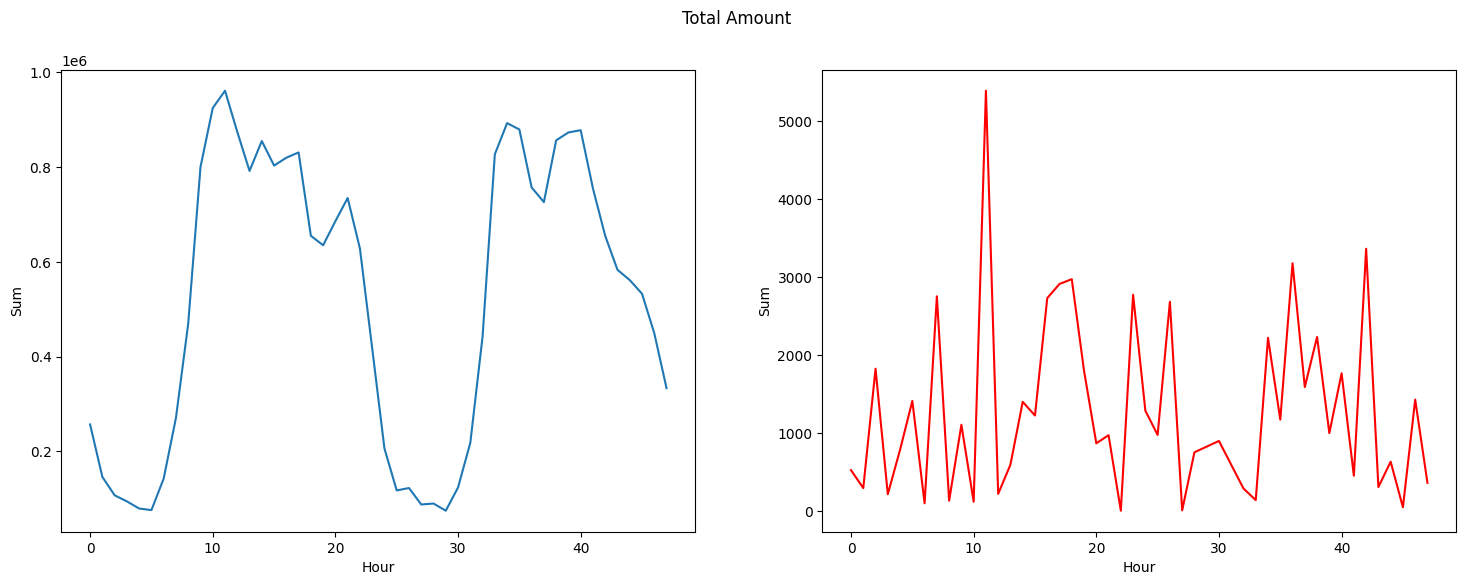

In [10]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(18,6))
s = sns.lineplot(ax = ax1, x="Hour", y="Sum", data=df.loc[df.Class==0])
s = sns.lineplot(ax = ax2, x="Hour", y="Sum", data=df.loc[df.Class==1], color="red")
plt.suptitle("Total Amount")
plt.show();

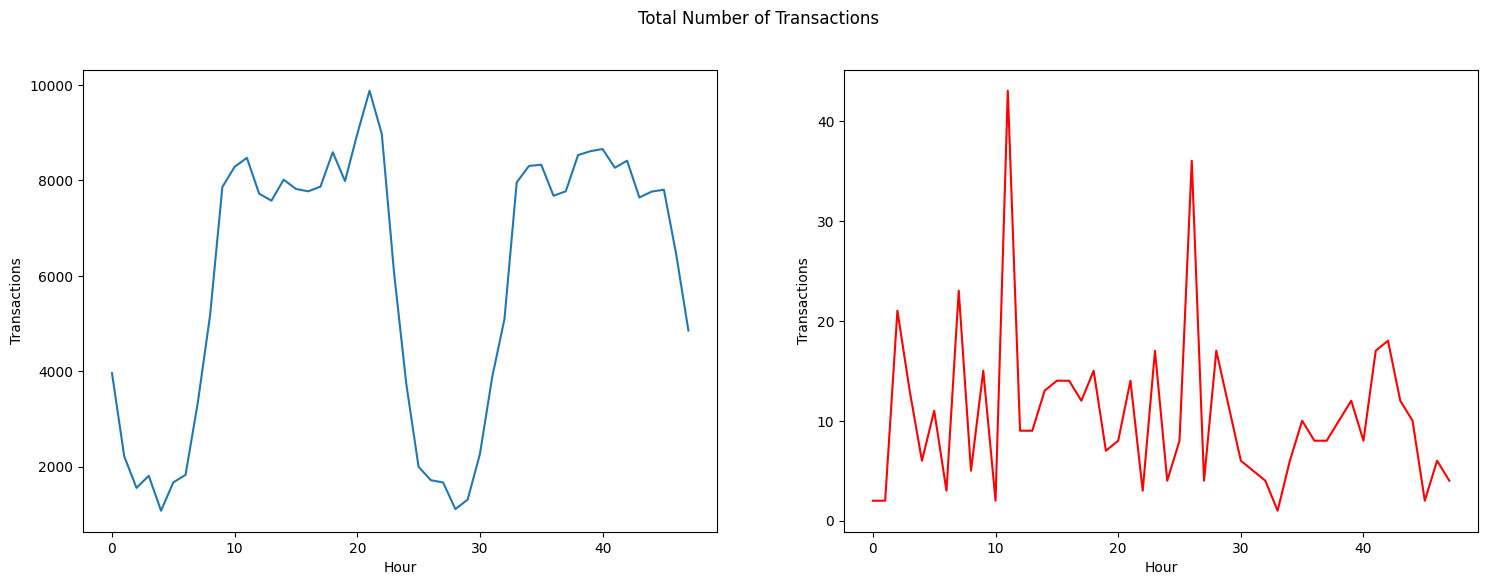

In [11]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(18,6))
s = sns.lineplot(ax = ax1, x="Hour", y="Transactions", data=df.loc[df.Class==0])
s = sns.lineplot(ax = ax2, x="Hour", y="Transactions", data=df.loc[df.Class==1], color="red")
plt.suptitle("Total Number of Transactions")
plt.show();

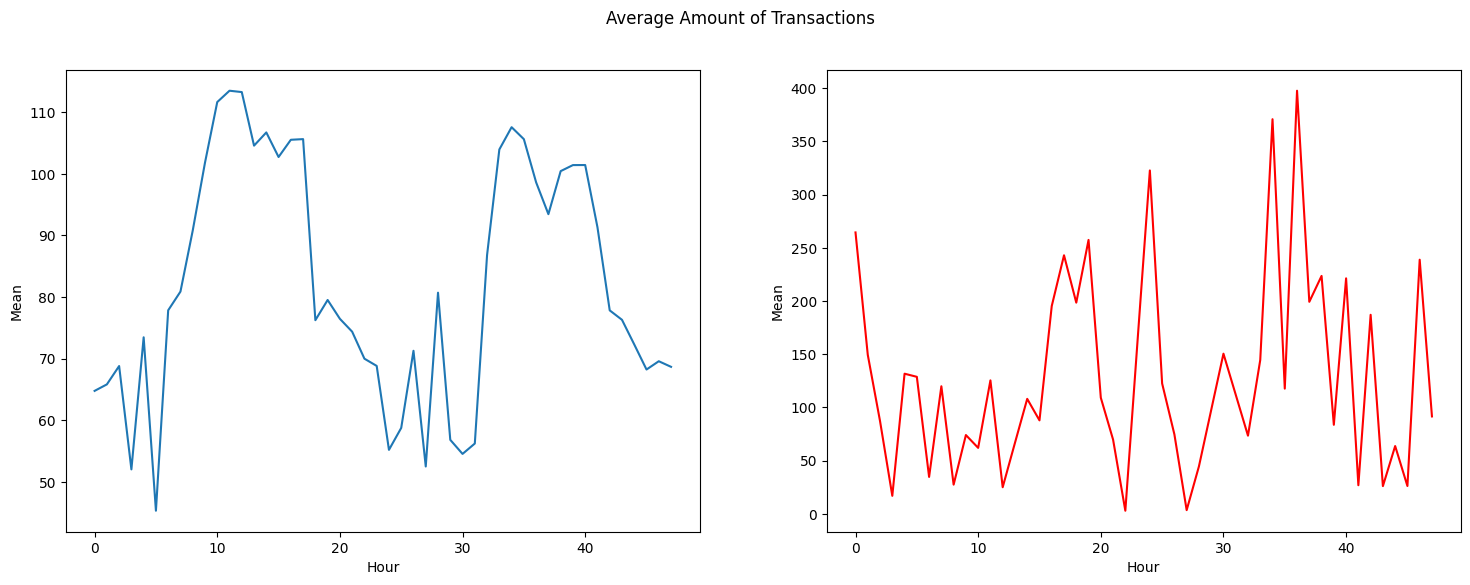

In [12]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(18,6))
s = sns.lineplot(ax = ax1, x="Hour", y="Mean", data=df.loc[df.Class==0])
s = sns.lineplot(ax = ax2, x="Hour", y="Mean", data=df.loc[df.Class==1], color="red")
plt.suptitle("Average Amount of Transactions")
plt.show();

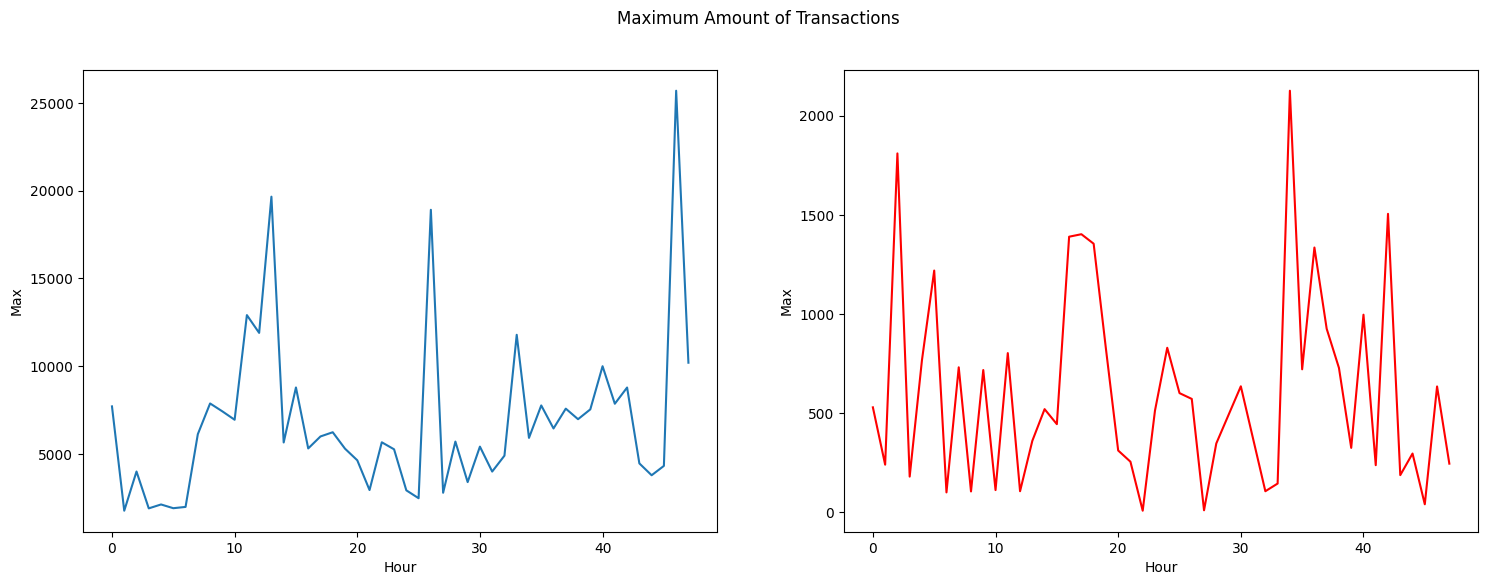

In [13]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(18,6))
s = sns.lineplot(ax = ax1, x="Hour", y="Max", data=df.loc[df.Class==0])
s = sns.lineplot(ax = ax2, x="Hour", y="Max", data=df.loc[df.Class==1], color="red")
plt.suptitle("Maximum Amount of Transactions")
plt.show();

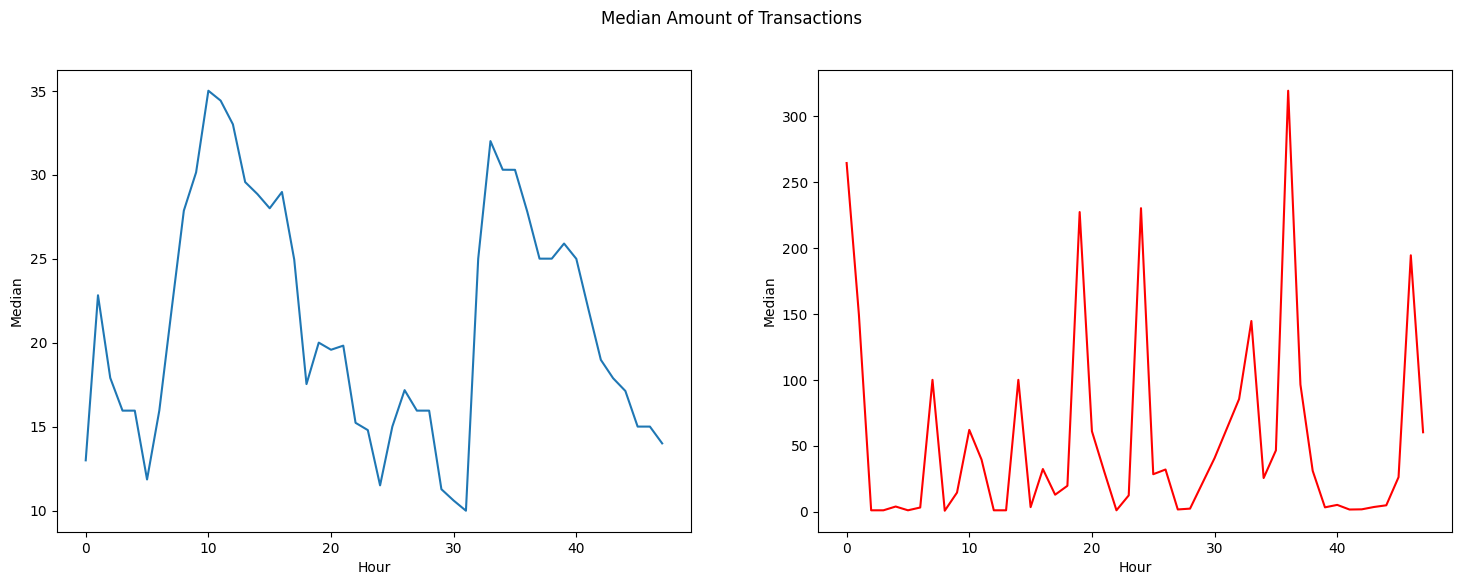

In [14]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(18,6))
s = sns.lineplot(ax = ax1, x="Hour", y="Median", data=df.loc[df.Class==0])
s = sns.lineplot(ax = ax2, x="Hour", y="Median", data=df.loc[df.Class==1], color="red")
plt.suptitle("Median Amount of Transactions")
plt.show();

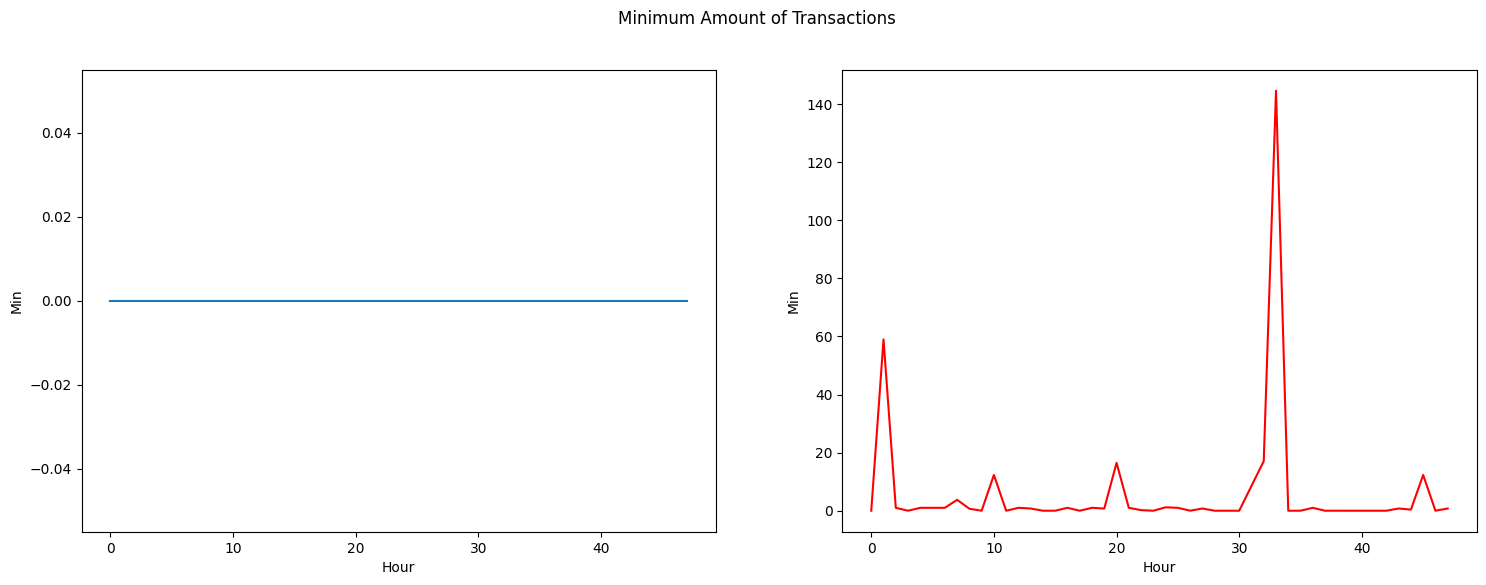

In [15]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(18,6))
s = sns.lineplot(ax = ax1, x="Hour", y="Min", data=df.loc[df.Class==0])
s = sns.lineplot(ax = ax2, x="Hour", y="Min", data=df.loc[df.Class==1], color="red")
plt.suptitle("Minimum Amount of Transactions")
plt.show();

## 交易金额

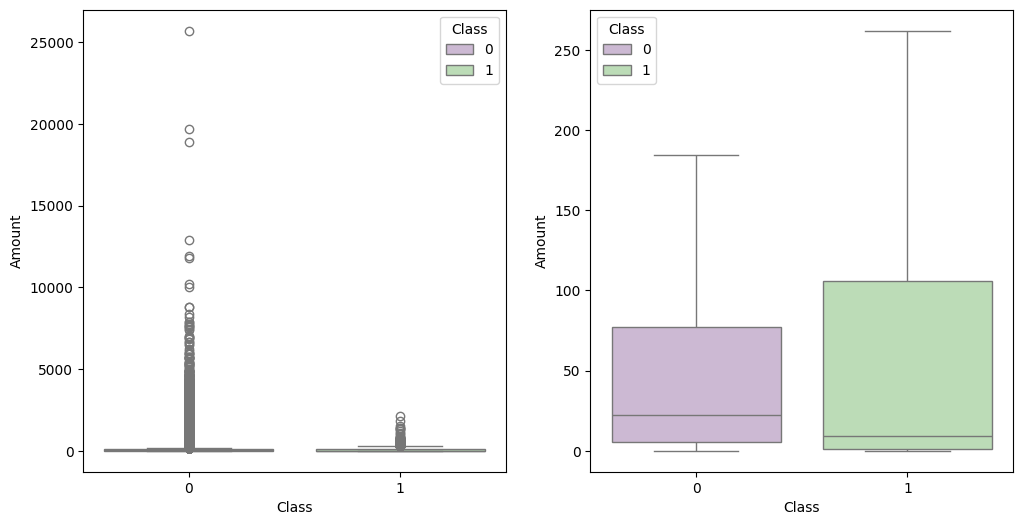

In [16]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12,6))
s = sns.boxplot(ax = ax1, x="Class", y="Amount", hue="Class",data=data_df, palette="PRGn",showfliers=True)
s = sns.boxplot(ax = ax2, x="Class", y="Amount", hue="Class",data=data_df, palette="PRGn",showfliers=False)
plt.show();

In [17]:
tmp = data_df[['Amount','Class']].copy()
class_0 = tmp.loc[tmp['Class'] == 0]['Amount']
class_1 = tmp.loc[tmp['Class'] == 1]['Amount']
class_0.describe()

count    284315.000000
mean         88.291022
std         250.105092
min           0.000000
25%           5.650000
50%          22.000000
75%          77.050000
max       25691.160000
Name: Amount, dtype: float64

In [18]:
class_1.describe()

count     492.000000
mean      122.211321
std       256.683288
min         0.000000
25%         1.000000
50%         9.250000
75%       105.890000
max      2125.870000
Name: Amount, dtype: float64

真实交易具有更高的均值（mean value）、更大的第一四分位数（Q1），但第三四分位数（Q3）和第四四分位数（Q4）较小，且存在更多离群值（outliers）；而欺诈交易的第一四分位数（Q1）和均值较低，第四四分位数（Q4）较大，离群值较少。

我们将欺诈交易的金额（amount）随时间的变化进行可视化。时间轴以秒为单位显示，起始点为观测周期起点（总时长48小时，跨2个自然日）。

In [19]:
fraud = data_df.loc[data_df['Class'] == 1]

trace = go.Scatter(
    x = fraud['Time'],y = fraud['Amount'],
    name="Amount",
     marker=dict(
                color='rgb(238,23,11)',
                line=dict(
                    color='red',
                    width=1),
                opacity=0.5,
            ),
    text= fraud['Amount'],
    mode = "markers"
)
data = [trace]
layout = dict(title = 'Amount of fraudulent transactions',
          xaxis = dict(title = 'Time [s]', showticklabels=True), 
          yaxis = dict(title = 'Amount'),
          hovermode='closest'
         )
fig = dict(data=data, layout=layout)
iplot(fig, filename='fraud-amount')

## 特征相关性

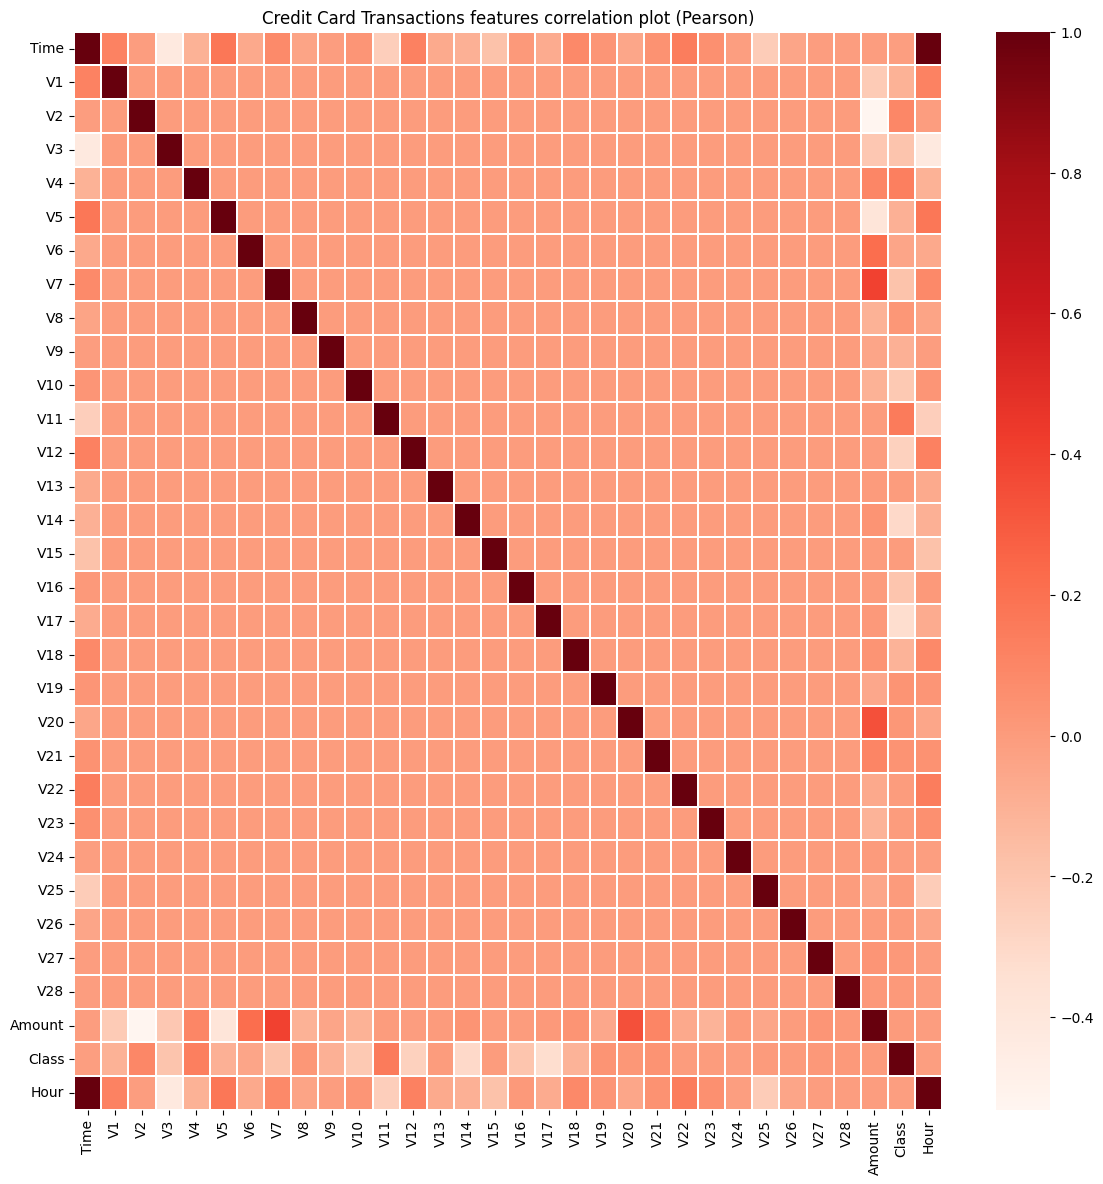

In [20]:
plt.figure(figsize = (14,14))
plt.title('Credit Card Transactions features correlation plot (Pearson)')
corr = data_df.corr()
sns.heatmap(corr,xticklabels=corr.columns,yticklabels=corr.columns,linewidths=.1,cmap="Reds")
plt.show()

正如预期，特征V1至V28之间不存在显著相关性。但其中部分特征与以下变量存在一定关联性：

Time（时间）：与 V3 呈负相关

Amount（交易金额）：

与 V7、V20 呈正相关

与 V1、V5 呈负相关

让我们将正相关和负相关的数值绘制在同一张图上。

首先从正相关数值开始：{V20;交易金额} 和 {V7;交易金额}。

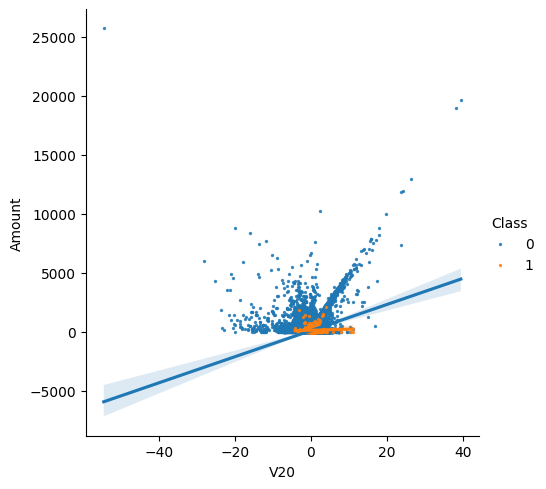

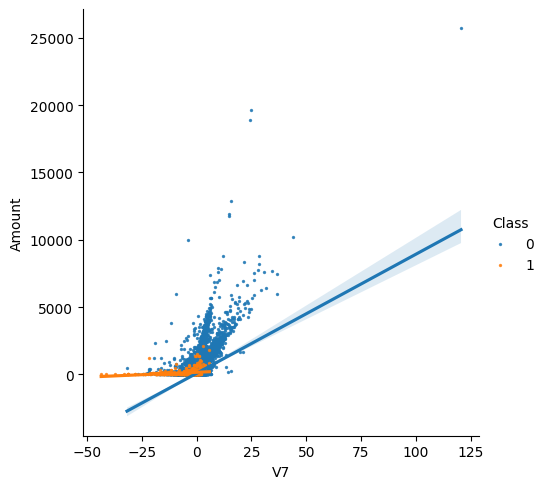

In [21]:
s = sns.lmplot(x='V20', y='Amount',data=data_df, hue='Class', fit_reg=True,scatter_kws={'s':2})
s = sns.lmplot(x='V7', y='Amount',data=data_df, hue='Class', fit_reg=True,scatter_kws={'s':2})
plt.show()

我们可以确认这两组特征存在相关性（Class = 0的回归线呈正斜率，而Class = 1的回归线虽然也是正斜率但更为平缓）。

现在我们来绘制负相关特征的图表。

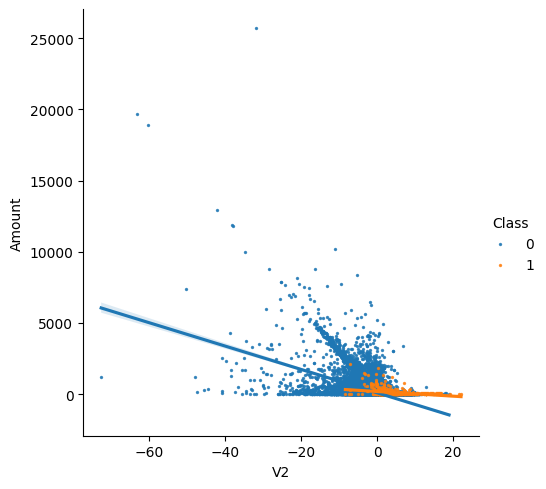

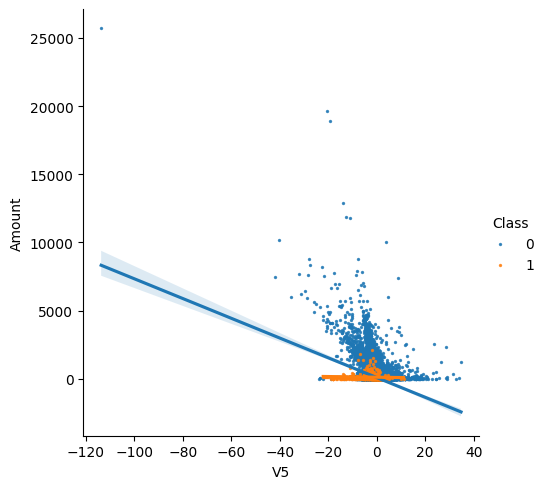

In [22]:
s = sns.lmplot(x='V2', y='Amount',data=data_df, hue='Class', fit_reg=True,scatter_kws={'s':2})
s = sns.lmplot(x='V5', y='Amount',data=data_df, hue='Class', fit_reg=True,scatter_kws={'s':2})
plt.show()

可以确认这两组特征呈负相关关系：

Class = 0的回归线显示为负斜率

Class = 1的回归线虽同为负斜率，但倾斜程度极其微弱


## 特征密度图

C:\Users\86181\AppData\Local\Temp\ipykernel_15652\955923673.py:14: UserWarning:



The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`.
Setting `bw_method=0.5`, but please see the docs for the new parameters
and update your code. This will become an error in seaborn v0.14.0.


C:\Users\86181\AppData\Local\Temp\ipykernel_15652\955923673.py:15: UserWarning:



The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`.
Setting `bw_method=0.5`, but please see the docs for the new parameters
and update your code. This will become an error in seaborn v0.14.0.


C:\Users\86181\AppData\Local\Temp\ipykernel_15652\955923673.py:14: UserWarning:



The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`.
Setting `bw_method=0.5`, but please see the docs for the new parameters
and update your code. This will become an error in seaborn v0.14.0.


C:\Users\86181\AppData\Local\Temp\ipykernel_15652\955923673.py:15: UserWarning:



The `bw` parameter i

<Figure size 640x480 with 0 Axes>

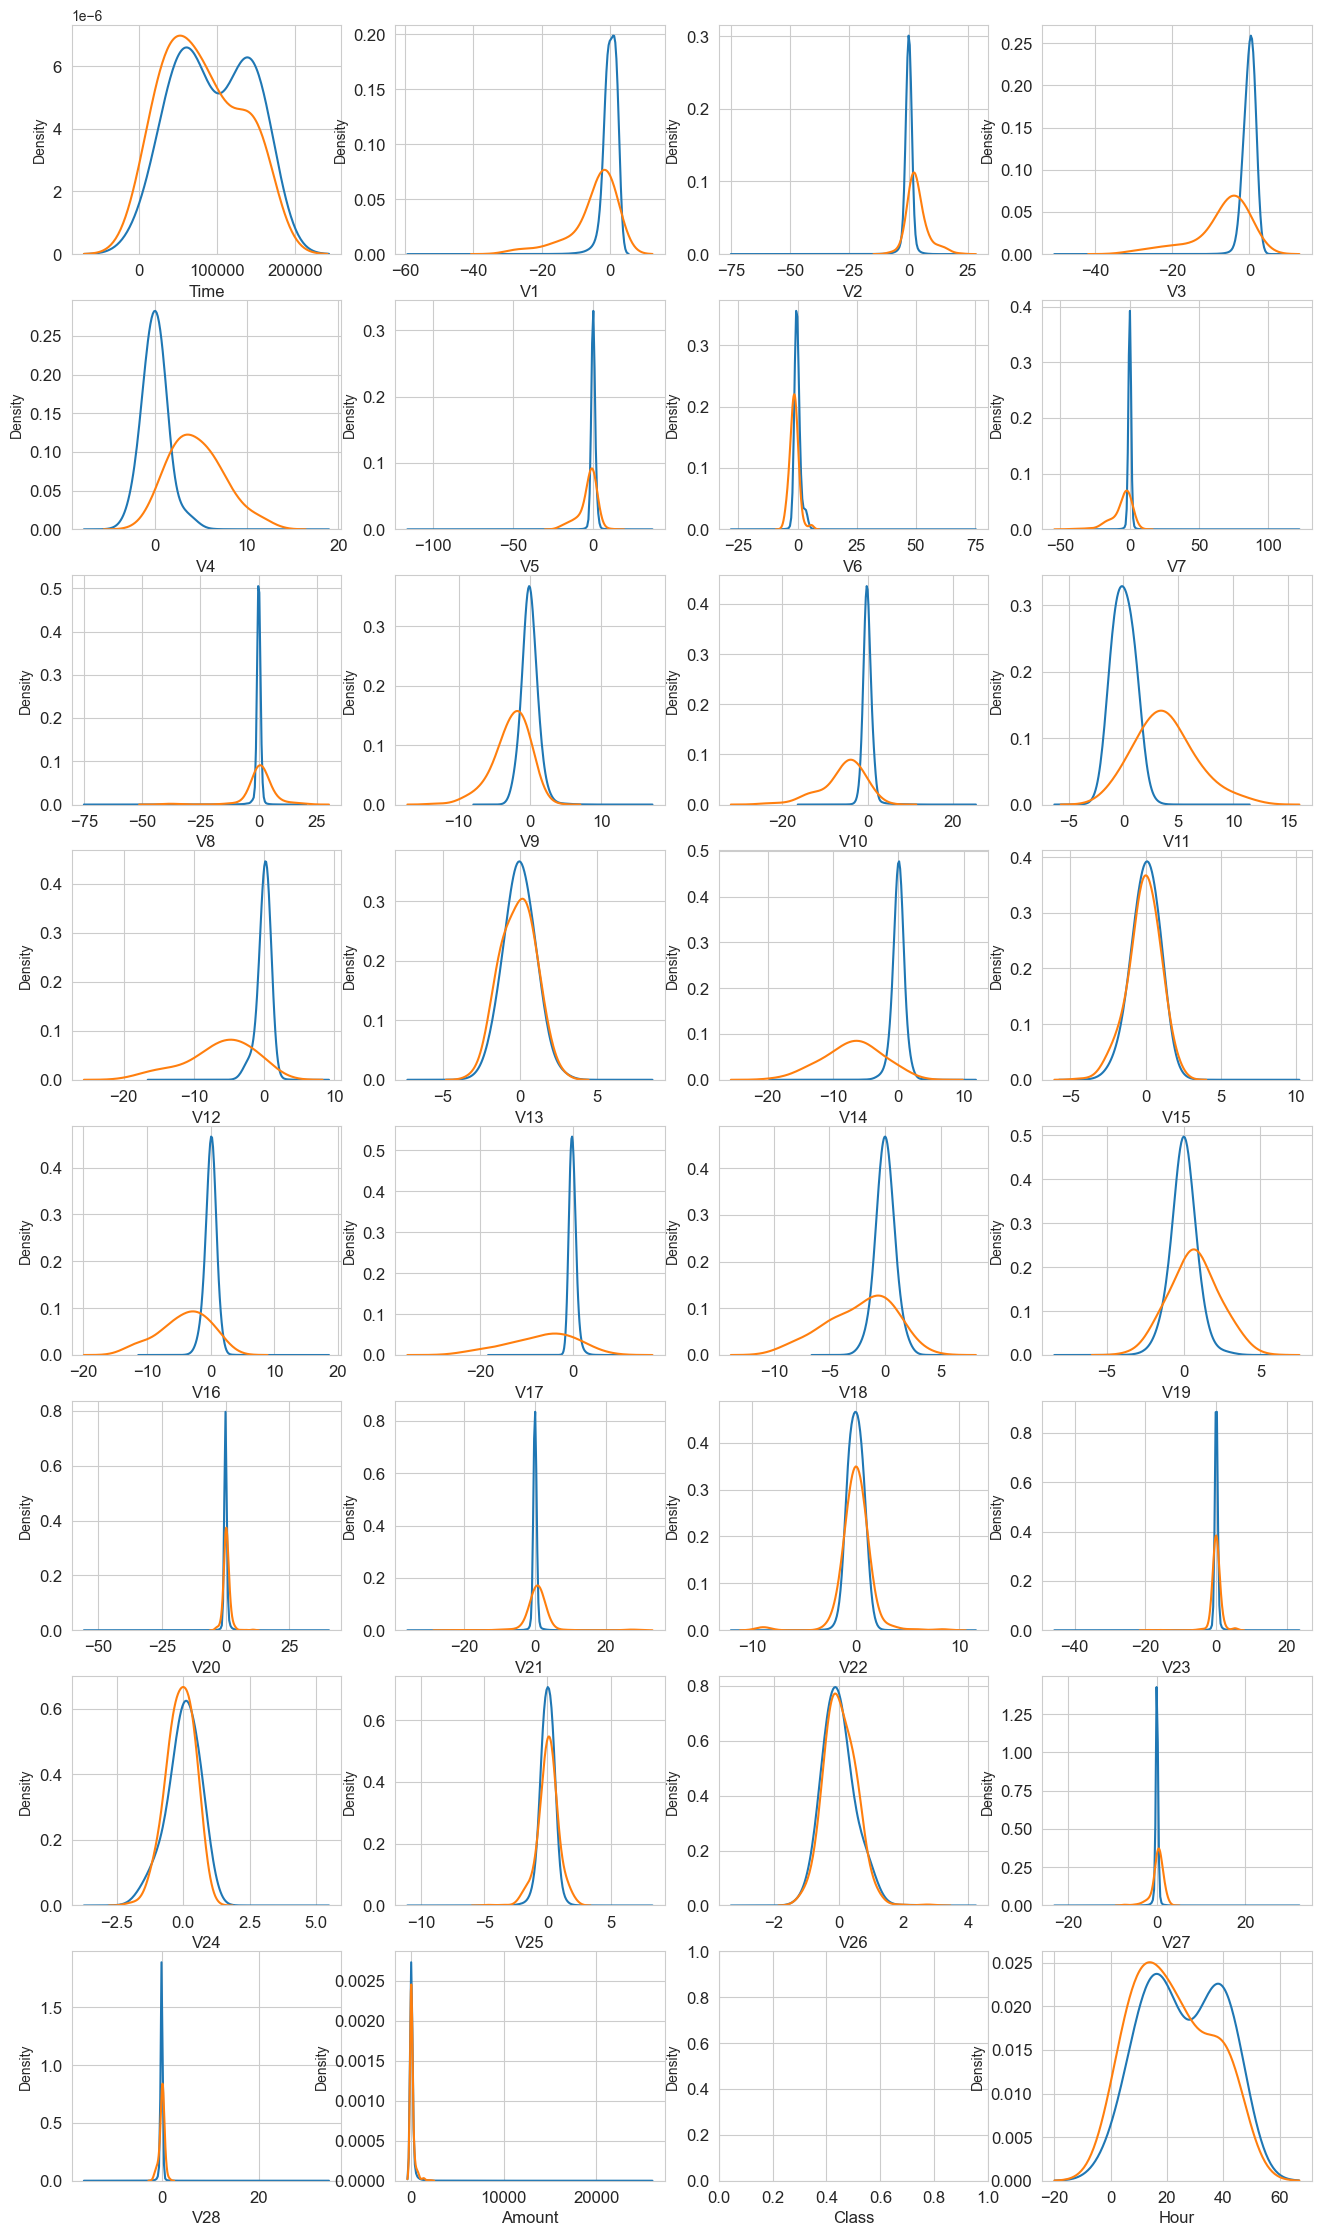

In [23]:
var = data_df.columns.values

i = 0
t0 = data_df.loc[data_df['Class'] == 0]
t1 = data_df.loc[data_df['Class'] == 1]

sns.set_style('whitegrid')
plt.figure()
fig, ax = plt.subplots(8,4,figsize=(16,28))

for feature in var:
    i += 1
    plt.subplot(8,4,i)
    sns.kdeplot(t0[feature], bw=0.5,label="Class = 0")
    sns.kdeplot(t1[feature], bw=0.5,label="Class = 1")
    plt.xlabel(feature, fontsize=12)
    locs, labels = plt.xticks()
    plt.tick_params(axis='both', which='major', labelsize=12)
plt.show();

从特征分布来看，部分特征对Class两类值的区分度表现如下：

显著可分特征

V4、V11：Class=0与Class=1的分布完全分离

部分可分特征

V12、V14、V18：存在部分重叠区域

差异较明显特征

V1、V2、V3、V10：分布形态显著不同

低区分度特征

V25、V26、V28：两类Class值分布高度相似

# <a id="6">预测模型</a>  



### 定义预测变量与目标变量

预测特征与目标特征定义
1. 预测特征

类型：均为数值型特征（本数据集无类别型特征）

包含：

PCA降维特征：V1-V28（标准化数值）

原始数值特征：

Time：交易时间戳（秒）

Amount：交易金额（连续值）

2. 目标特征

变量：Class

类型：二元数值标签

0：合法交易

1：欺诈交易

特性：

极端类别不平衡（欺诈交易<0.1%）

建议使用F1-Score/PR-AUC评估

3. 类别型特征说明

明确标注：本数据集不含类别型特征

In [24]:
target = 'Class'
predictors = ['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',\
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19',\
       'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28',\
       'Amount']

### 将数据分割为训练集、测试集和验证集

定义训练集、测试集和验证集

In [25]:
train_df, test_df = train_test_split(data_df, test_size=TEST_SIZE, random_state=RANDOM_STATE, shuffle=True )
train_df, valid_df = train_test_split(train_df, test_size=VALID_SIZE, random_state=RANDOM_STATE, shuffle=True )

## <a id="61">随机森林</a>


### 定义模型参数

使用训练集进行模型训练，然后通过验证集进行验证。


我们将采用基尼系数(GINI)作为验证标准，其计算公式为GINI = 2 × (AUC) - 1，其中AUC指受试者工作特征曲线下面积(ROC-AUC)<a href='#8'>[4]</a>。模型参数设置为：评估器数量100个，并行任务数4个。

初始化随机森林

In [26]:
clf = RandomForestClassifier(n_jobs=NO_JOBS, 
                             random_state=RANDOM_STATE,
                             criterion=RFC_METRIC,
                             n_estimators=NUM_ESTIMATORS,
                             verbose=False,
                             class_weight='balanced')

使用 train_df 数据和 fit 函数训练 RandomForestClassifier（随机森林分类器）。

In [27]:
clf.fit(train_df[predictors], train_df[target].values)

RandomForestClassifier(class_weight='balanced', n_jobs=4, random_state=2018,
                       verbose=False)

现在使用 predict 函数对 valid_df 数据进行目标值预测。

In [28]:
preds = clf.predict(valid_df[predictors])

让我们同时可视化特征重要性。

### 特征重要性

C:\Users\86181\AppData\Local\Temp\ipykernel_15652\499894721.py:6: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.



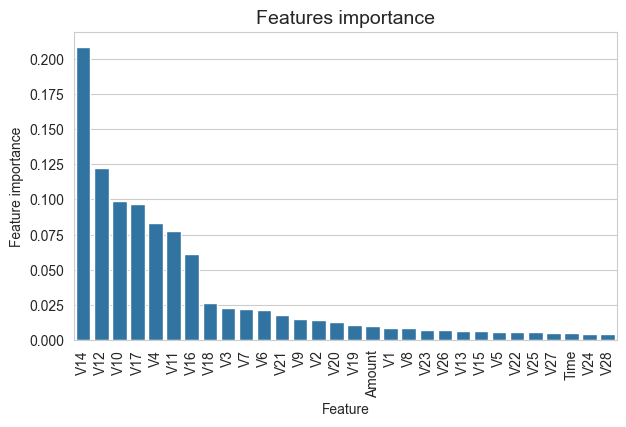

In [29]:
tmp = pd.DataFrame({'Feature': predictors, 'Feature importance': clf.feature_importances_})
tmp = tmp.sort_values(by='Feature importance',ascending=False)
plt.figure(figsize = (7,4))
plt.title('Features importance',fontsize=14)
s = sns.barplot(x='Feature',y='Feature importance',data=tmp)
s.set_xticklabels(s.get_xticklabels(),rotation=90)
plt.show()   


最重要的特征是 **V17**, **V12**, **V14**, **V10**, **V11**, **V16**.


### 混淆矩阵

显示所得结果的混淆矩阵

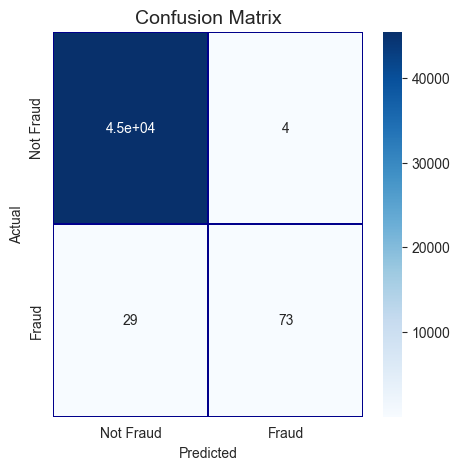

In [30]:
cm = pd.crosstab(valid_df[target].values, preds, rownames=['Actual'], colnames=['Predicted'])
fig, (ax1) = plt.subplots(ncols=1, figsize=(5,5))
sns.heatmap(cm, 
            xticklabels=['Not Fraud', 'Fraud'],
            yticklabels=['Not Fraud', 'Fraud'],
            annot=True,ax=ax1,
            linewidths=.2,linecolor="Darkblue", cmap="Blues")
plt.title('Confusion Matrix', fontsize=14)
plt.show()

计算 ROC-AUC 得分<a href='#8'>[4]</a>.

### 曲线下面积

In [31]:
roc_auc_score(valid_df[target].values, preds)

np.float64(0.8577991493075996)

使用随机森林分类器(RandomForestClassifier)得到的ROC曲线下面积(ROC-AUC)分数为0.86。





## <a id="62">自适应提升分类器</a>



### 模型准备

模型参数设置与初始化

In [32]:
clf = AdaBoostClassifier(random_state=2018,
                        algorithm='SAMME',
                        learning_rate=0.8,
                        n_estimators=NUM_ESTIMATORS)

### 训练模型

In [33]:
sample_weight = np.where(train_df[target].values == 1, 5.0, 1.0)
clf.fit(train_df[predictors], train_df[target].values,sample_weight=sample_weight)

d:\Anaconda3\envs\fin\lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning:

The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.



AdaBoostClassifier(algorithm='SAMME', learning_rate=0.8, n_estimators=100,
                   random_state=2018)

### 预测目标值

现在使用predict函数对valid_df验证集数据进行目标值预测。

In [34]:
preds = clf.predict(valid_df[predictors])

### 特征的重要性

C:\Users\86181\AppData\Local\Temp\ipykernel_15652\3992975389.py:6: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.



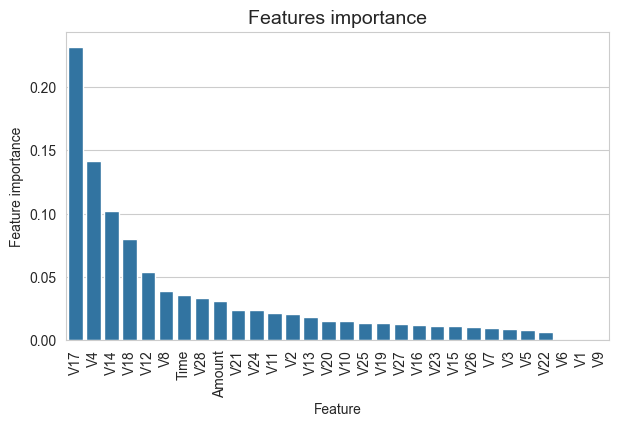

In [35]:
tmp = pd.DataFrame({'Feature': predictors, 'Feature importance': clf.feature_importances_})
tmp = tmp.sort_values(by='Feature importance',ascending=False)
plt.figure(figsize = (7,4))
plt.title('Features importance',fontsize=14)
s = sns.barplot(x='Feature',y='Feature importance',data=tmp)
s.set_xticklabels(s.get_xticklabels(),rotation=90)
plt.show()   

### 混淆矩阵


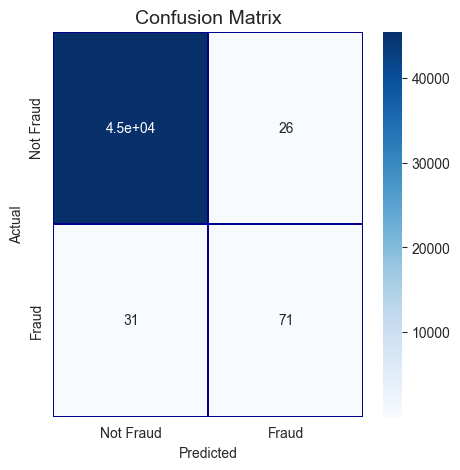

In [36]:
cm = pd.crosstab(valid_df[target].values, preds, rownames=['Actual'], colnames=['Predicted'])
fig, (ax1) = plt.subplots(ncols=1, figsize=(5,5))
sns.heatmap(cm, 
            xticklabels=['Not Fraud', 'Fraud'],
            yticklabels=['Not Fraud', 'Fraud'],
            annot=True,ax=ax1,
            linewidths=.2,linecolor="Darkblue", cmap="Blues")
plt.title('Confusion Matrix', fontsize=14)
plt.show()

计算 ROC-AUC.


### 曲线下的面积

使用自适应增强分类器(AdaBoostClassifier)获得的ROC曲线下面积(ROC-AUC)分数为0.85。

## <a id="63">XGBoost</a>

XGBoost 是一种梯度提升算法 


### 模型准备

我们初始化用于训练和验证的 DMatrix 对象（基于数据集），并设置部分模型调参参数。

In [44]:
# Prepare the train and valid datasets
dtrain = xgb.DMatrix(train_df[predictors], train_df[target].values)
dvalid = xgb.DMatrix(valid_df[predictors], valid_df[target].values)
dtest = xgb.DMatrix(test_df[predictors], test_df[target].values)

#What to monitor (in this case, **train** and **valid**)
watchlist = [(dtrain, 'train'), (dvalid, 'valid')]

# Set xgboost parameters
params = {}
params['objective'] = 'binary:logistic'
params['eta'] = 0.039
params['silent'] = True
params['max_depth'] = 2
params['subsample'] = 0.8
params['colsample_bytree'] = 0.9
params['eval_metric'] = 'auc'
params['random_state'] = RANDOM_STATE

### 训练模型


In [45]:
model = xgb.train(params, 
                dtrain, 
                MAX_ROUNDS, 
                watchlist, 
                early_stopping_rounds=EARLY_STOP, 
                maximize=True, 
                verbose_eval=VERBOSE_EVAL)

d:\Anaconda3\envs\fin\lib\site-packages\xgboost\core.py:723: FutureWarning:

Pass `evals` as keyword args.

d:\Anaconda3\envs\fin\lib\site-packages\xgboost\core.py:158: UserWarning:

[21:32:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "silent" } are not used.




[0]	train-auc:0.94070	valid-auc:0.88630
[50]	train-auc:0.94200	valid-auc:0.89009
[100]	train-auc:0.97584	valid-auc:0.96685
[150]	train-auc:0.98525	valid-auc:0.97960
[200]	train-auc:0.99279	valid-auc:0.98495
[250]	train-auc:0.99493	valid-auc:0.98352
[258]	train-auc:0.99519	valid-auc:0.98386


The best validation score (ROC-AUC) was **0.984**, for round **258**.

### 绘制变量重要性图表

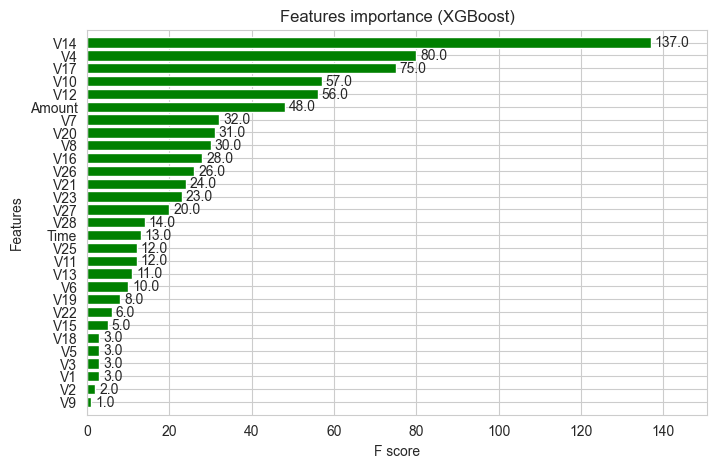

In [46]:
fig, (ax) = plt.subplots(ncols=1, figsize=(8,5))
xgb.plot_importance(model, height=0.8, title="Features importance (XGBoost)", ax=ax, color="green") 
plt.show()

### 测试集预测


我们已使用训练集和验证集完成模型训练与调优，现在将使用训练好的模型对测试集进行目标值预测。

In [47]:
preds = model.predict(dtest)

### 曲线下的面积



In [48]:
roc_auc_score(test_df[target].values, preds)

np.float64(0.9803156765502444)

测试集预测的AUC得分为0.980

## <a id="64">LightGBM</a>


继续使用另一种梯度提升算法：LightGBM <a href='#8'></a> <a href='#8'></a>.


### 定义模型参数

设置初始LightGBM模型参数

In [49]:
params = {
          'boosting_type': 'gbdt',
          'objective': 'binary',
          'metric':'auc',
          'learning_rate': 0.05,
          'num_leaves': 7,  # we should let it be smaller than 2^(max_depth)
          'max_depth': 4,  # -1 means no limit
          'min_child_samples': 100,  # Minimum number of data need in a child(min_data_in_leaf)
          'max_bin': 100,  # Number of bucketed bin for feature values
          'subsample': 0.9,  # Subsample ratio of the training instance.
          'subsample_freq': 1,  # frequence of subsample, <=0 means no enable
          'colsample_bytree': 0.7,  # Subsample ratio of columns when constructing each tree.
          'min_child_weight': 0,  # Minimum sum of instance weight(hessian) needed in a child(leaf)
          'min_split_gain': 0,  # lambda_l1, lambda_l2 and min_gain_to_split to regularization
          'nthread': 8,
          'verbose': 0,
          'scale_pos_weight':150, # because training data is extremely unbalanced 
         }

### 模型准备
准备模型数据：从训练集和验证集创建 Dataset 数据结构

In [50]:
dtrain = lgb.Dataset(train_df[predictors].values, 
                     label=train_df[target].values,
                     feature_name=predictors)

dvalid = lgb.Dataset(valid_df[predictors].values,
                     label=valid_df[target].values,
                     feature_name=predictors)

### 模型运行

运行模型：使用 train 函数进行训练

In [51]:
evals_result = {}  # 用于记录评估结果

model = lgb.train(
    params,
    dtrain,
    num_boost_round=MAX_ROUNDS,
    valid_sets=[dtrain, dvalid],
    valid_names=['train', 'valid'],
    callbacks=[
        early_stopping(stopping_rounds=2*EARLY_STOP),
        log_evaluation(period=VERBOSE_EVAL),
        record_evaluation(evals_result)  # 记录评估结果
    ]
)


Training until validation scores don't improve for 100 rounds
[50]	train's auc: 0.997909	valid's auc: 0.952288
[100]	train's auc: 0.999032	valid's auc: 0.945553
Early stopping, best iteration is:
[29]	train's auc: 0.996594	valid's auc: 0.957864


最佳验证得分出现在第 29 轮，此时 AUC 约等于 0.958。

现在绘制变量重要性图。

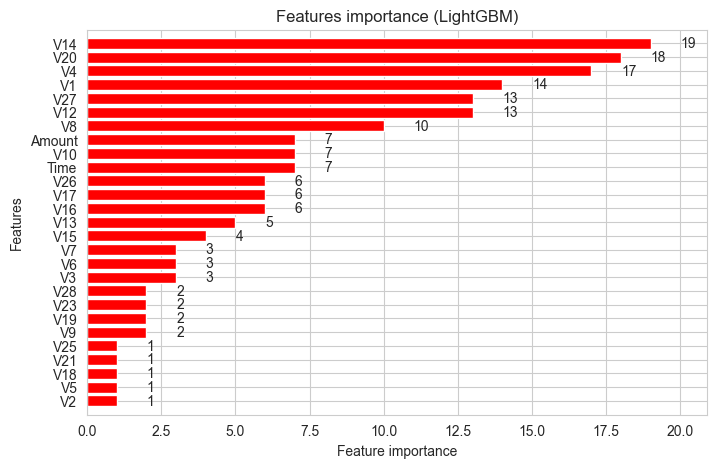

In [52]:
fig, (ax) = plt.subplots(ncols=1, figsize=(8,5))
lgb.plot_importance(model, height=0.8, title="Features importance (LightGBM)", ax=ax,color="red") 
plt.show()

### 预测测试集

In [53]:
preds = model.predict(test_df[predictors])

### 曲线下的面积

In [54]:
roc_auc_score(test_df[target].values, preds)

np.float64(0.9473337202349548)

测试集获得的 ROC曲线下面积（ROC-AUC） 分数为 0.947。

### 采用交叉验证进行训练与验证

现在我们将采用交叉验证方法，具体使用5折K折交叉验证（KFolds）。数据将被平均分为5份，通过轮换方式，每次使用其中4份（n-1）作为训练集，剩余的第5份（第n份）作为验证集。

测试集预测结果是各次交叉验证预测的平均值

In [55]:
kf = KFold(n_splits=NUMBER_KFOLDS, random_state=RANDOM_STATE, shuffle=True)

# Create arrays and dataframes to store results
oof_preds = np.zeros(train_df.shape[0])
test_preds = np.zeros(test_df.shape[0])
feature_importance_df = pd.DataFrame()

for n_fold, (train_idx, valid_idx) in enumerate(kf.split(train_df)):
    train_x, train_y = train_df[predictors].iloc[train_idx], train_df[target].iloc[train_idx]
    valid_x, valid_y = train_df[predictors].iloc[valid_idx], train_df[target].iloc[valid_idx]
    
    model = LGBMClassifier(
        n_jobs=-1,
        early_stopping_rounds=EARLY_STOP,
        n_estimators=2000,
        learning_rate=0.01,
        num_leaves=80,
        colsample_bytree=0.98,
        subsample=0.78,
        reg_alpha=0.04,
        reg_lambda=0.073,
        boosting_type='gbdt',
        min_split_gain=0.025,
        min_child_weight=40,
        min_child_samples=510,
        objective='binary',
        metric='auc',
        verbose=VERBOSE_EVAL  # 替换已弃用的 silent 参数
    )
    
    model.fit(
        train_x, train_y,
        eval_set=[(train_x, train_y), (valid_x, valid_y)],
        eval_metric='auc',
        
    )
    
    oof_preds[valid_idx] = model.predict_proba(valid_x, num_iteration=model.best_iteration_)[:, 1]
    test_preds += model.predict_proba(test_df[predictors], num_iteration=model.best_iteration_)[:, 1] / kf.n_splits
    
    # 修正变量名：clf -> model
    fold_importance_df = pd.DataFrame({
        "feature": predictors,
        "importance": model.feature_importances_,
        "fold": n_fold + 1
    })
    
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    print(f'Fold {n_fold + 1:2d} AUC : {roc_auc_score(valid_y, oof_preds[valid_idx]):.6f}')
    
    del model, train_x, train_y, valid_x, valid_y
    gc.collect()

train_auc_score = roc_auc_score(train_df[target], oof_preds)
print(f'Full AUC score {train_auc_score:.6f}')

[LightGBM] [Warning] early_stopping_round is set=50, early_stopping_rounds=50 will be ignored. Current value: early_stopping_round=50
[LightGBM] [Info] Number of positive: 233, number of negative: 145587
[LightGBM] [Debug] Dataset::GetMultiBinFromAllFeatures: sparse rate 0.000216
[LightGBM] [Debug] init for col-wise cost 0.000003 seconds, init for row-wise cost 0.005409 seconds
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.023175 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7650
[LightGBM] [Info] Number of data points in the train set: 145820, number of used features: 30
[LightGBM] [Warning] early_stopping_round is set=50, early_stopping_rounds=50 will be ignored. Current value: early_stopping_round=50
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001598 -> initscore=-6.437491
[LightGBM] [Info] Start training from score -6.437491
[LightGBM] [Warning] No further splits with positive gain, be

测试集预测结果的AUC分数为0.93。
（我们通过对5折交叉验证的测试预测结果取平均值得出最终预测。）

In [56]:
pred = test_preds

# <a id="7">结论</a>

我们首先对数据进行了全面分析，包括检查数据不平衡性、特征可视化以及理解特征间关联性。随后探索了两种预测模型，并将数据划分为三部分：训练集、验证集和测试集。前三个模型仅使用训练集和测试集进行评估。

具体模型表现如下：

随机森林分类器 (RandomForestClassifier)

测试集预测AUC分数：0.85

自适应提升分类器 (AdaBoostClassifier)

测试集预测AUC分数：0.83（性能较随机森林略有下降）

CatBoost分类器

经过500轮迭代训练后

测试集AUC分数：0.86

XGBoost模型

采用验证集进行模型调优

最佳验证AUC分数：0.984

测试集预测AUC分数：0.974（当前最优）

LightGBM模型

训练-验证分割法：

验证集AUC：0.974

测试集AUC：0.946

交叉验证法：

测试集平均AUC：0.93

（注：所有AUC分数均基于二分类任务标准，0.9以上表明模型具有极强的欺诈交易识别能力）